## Simulated Annealing on the Traveling Salesman problem##

 States: A full path represented as a list for the order of cities to travel. For example, [0,1,0] says "Go from city 0 to city 1 to city 0".

https://medium.com/@francis.allanah/travelling-salesman-problem-using-simulated-annealing-f547a71ab3c6

In [207]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt

def SA_TS(dist_mat, T, start_city, mean, sigma, temp_penalty):

    # Total distance for current path
    def objective_function(dist_mat, state):
        cost = 0
        for i in range(len(state) - 2):
            cost += dist_mat[state[i], state[i+1]]
        cost += dist_mat[state[-1],state[-2]]
        return cost
    
    def switch_two(state):
        # ex: a,b = 2,5
        # [1, 2, 3, 4, 5, 6] -> [1, 5, 3, 4, 2, 6]
        a = random.randint(1, len(state)-2)
        b = random.randint(1, len(state)-2)
        while b == a:
            b = random.randint(1, len(state)-2)
        state[a], state[b] = state[b], state[a]
        return state
    
    def invert_path_between(state):
        # ex: a,b = 2,5
        # [1, 2, 3, 4, 5, 6] -> [1, 4, 3, 2, 5, 6]
        a = random.randint(1, len(state)-2)
        b = random.randint(1, len(state)-2)
        while b == a:
            b = random.randint(1, len(state)-2)    
        if b < a:
            a,b = b,a   
        state[a:b] = state[a:b][::-1] # reverse sublist
        return state

    def insert_random(state):
        # ex: a,b = 2,5 (by position)
        # [1, 2, 3, 4, 5, 6] -> [1, 3, 4, 5, 2, 6]
        a = random.randint(1, len(state)-2)
        b = random.randint(1, len(state)-2)
        while b == a:
            b = random.randint(1, len(state)-2)    
        city = state.pop(a)
        state.insert(b, city) 
        return state
    
    def swap_subroute(state):
        a = random.randint(1, len(state)-2)
        b = random.randint(1, len(state)-2)
        while b == a:
            b = random.randint(1, len(state)-2)  
        if b < a:
            a,b = b,a  
        subroute = state[a:b]
        state = [x for x in range(len(state)-1) if x not in subroute]
        c = random.randint(1, len(state)-1)
        state[c:c] = subroute
        state.append(state[0])
        return state

    randomize_type = ['Swap 2', 'Insert', 'Swap Subroute', 'Invert']
    
    # Initial path: 0 -> 1, 1 -> 2, ... N-1 -> N
    initial = [i for i in range(len(dist_mat))]
    initial.remove(start_city)
    initial.insert(0,start_city)
    initial.append(start_city)
    
    p_array = []
    distance_array = []
    best_array = []
    
    path = initial 
    current_distance = objective_function(dist_mat, path)
    best_distance = current_distance
    best_path = initial
    
    for t in range(T,1,-1):

        distance_array.append(current_distance)
        
        random_type = random.choice(randomize_type)

        if random_type == 'Swap 2':
            new_path = switch_two(path)
        elif random_type == 'Insert':
            new_path = insert_random(path)
        elif random_type == 'Swap Subroute':
            new_path = swap_subroute(path)
        elif random_type == 'Invert':
            new_path = invert_path_between(path)
                    
        new_distance = objective_function(dist_mat, new_path)
        E = current_distance - new_distance
                
        if new_distance < best_distance:
            best_distance = new_distance
            best_path = new_path
            best_array.append(best_distance)
        
        # new path is shorter
        if E > 0:
            current_distance = new_distance
            path = new_path
            
        else:
            
            temp = (t+1)/(temp_penalty*T)        
            Z = (E-mean)/sigma # allows temp to scale probability smoothly
            p = np.exp(Z/temp) # probability of keeping bad new path -> 0 as time goes on
            p_array.append(p)
            
            # roll whether to keep longer new path anyway
            if np.random.binomial(1, p) == 1:
                current_distance = new_distance
                path = new_path
        
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout(pad = 5)    
        
    plt.subplot(1, 2, 1)  
    plt.plot(distance_array)
    plt.title('Search path (by objective function)')
    plt.ylabel('Path distance')
    plt.xlabel('Temperature (iteration)')
    plt.subplot(1,2,2)
    plt.scatter(np.arange(len(p_array)), p_array, s=5, c = p_array, cmap='viridis_r')
    plt.title('Progressive probability')
    plt.ylabel('Probability')
    plt.xlabel('Partial iteration')
    plt.show()

    return best_path, best_distance

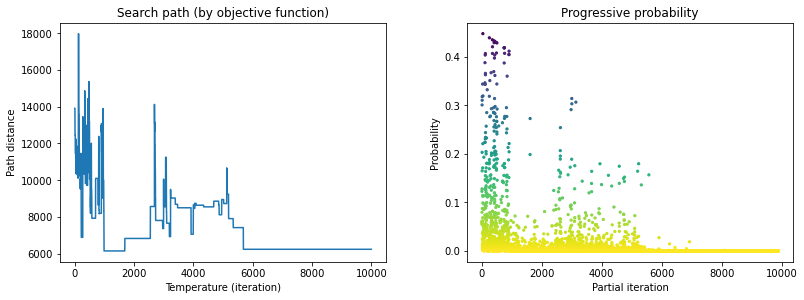

([0, 15, 3, 5, 11, 8, 6, 14, 4, 7, 1, 9, 16, 2, 10, 13, 12, 0], 6150.0)

In [217]:
import numpy as np
import pandas as pd

def write_distance_matrix(n, mean, sigma):
    distance_matrix = np.zeros((n, n))

    for row in range(n):
        for col in range(n):
            distance = 0
            while distance <= 0:
                distance = np.random.normal(mean, sigma)
                distance_matrix[row][col] = round(distance,-1)
            if row == col:
                distance_matrix[row][col] = 0
    return distance_matrix
 
T = 10000
N = 17
mean = 100
sigma = 1000
temp_penalty = .8 # higher -> lower probability of accepting bad routes
distance_matrix = pd.DataFrame(write_distance_matrix(N, mean, sigma))
#display(distance_matrix)

SA_TS(distance_matrix.to_numpy(), T, start_city = 0, mean = sigma, sigma = sigma, temp_penalty = temp_penalty)